In [3]:
import numpy as np
import GPy
import GPyOpt
import math
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [4]:
from functionDoESpecial import functionDoESpecial, function_dimensions, function_names
from binomial_optimization import optimization_step, value_generator

In [15]:
f_name = 'rosenbrock5'

# Comparison of GP and GGPM with binomial distribution

In [25]:
n_trials = 20
n_iteration = 60
initial_size = 15
bound = 100
dims = 2

np.random.seed(7)

objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)
init_design = GPyOpt.experiment_design.initial_design('random', feasible_region, initial_size)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

init_values = value_generator(init_design, objective, n_trials=n_trials).reshape(-1, 1)

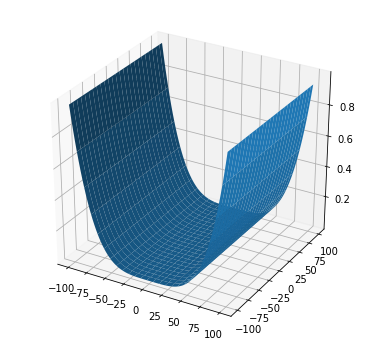

In [26]:
xs = np.linspace(-bound, bound, 100)
ys = np.linspace(-bound, bound, 100)
xs, ys = np.meshgrid(xs, ys)
values = objective(np.dstack([xs, ys]).reshape(10000, 2)).reshape(100, 100)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(xs, ys, values, rstride=4, cstride=4, linewidth=0)

Gaussian inference

In [27]:
ker_g = GPy.kern.RBF(dims)

In [ ]:
agg = []

for m in [1, 2, 5, 10]:
    
    mult = []
    
    for attempt in range(10):

        X_g = init_design
        Y_g = init_values * m
        trials_g = np.ones(len(X_g)).reshape(-1, 1) * n_trials * m

        m_g = GPy.models.GPRegression(X_g, Y_g / trials_g, ker_g)
        m_g.optimize()

        model_mins_g = []
        model_mins_g.append(np.min(m_g.predict(X_g)[0]))
        
        model_argmins_g = []
        model_argmins_g.append(np.argmin(m_g.predict(X_g)[0]))

        for i in range(n_iteration):
            v_g = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X_g, Y_g, trials_g, m_g = optimization_step(X_g, Y_g, v_g, lower_bounds=lower_bounds,\
                                                        upper_bounds=upper_bounds, trials=trials_g,\
                                                        n_trials_low=n_trials*m, kernel=ker_g)
            model_mins_g.append(np.min(m_g.predict(X_g)[0]))
            model_argmins_g.append(np.argmin(m_g.predict(X_g)[0]))
        
        mult.append(np.array([np.array(model_mins_g), X_g, Y_g, trials_g, np.array(model_argmins_g)]))
        
    agg.append(mult)
    
agg = np.array(agg)

Approx inference

In [ ]:
ker_l = GPy.kern.RBF(dims)

In [ ]:
agg_l = []

for m in [1, 2]:
    
    mult = []
    
    for attempt in range(5):

        X_l = init_design
        Y_l = init_values * m
        trials_l = np.ones(len(X_l)).reshape(-1, 1) * n_trials * m

        m_l = GPy.core.GP(X_l, Y_l, kernel=ker_l, 
                          Y_metadata={'trials': trials_l},
                          inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                          likelihood=GPy.likelihoods.Binomial())
        m_l.optimize()

        lik = GPy.likelihoods.Bernoulli()
        model_mins_l = []
        model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))
        
        model_argmins_l = []
        model_argmins_l.append(np.argmin(m_l._raw_predict(X_l)[0]))

        for i in range(n_iteration):
            v_l = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X_l, Y_l, trials_l, m_l = optimization_step(X_l, Y_l, v_l, lower_bounds=lower_bounds,\
                                                        upper_bounds=upper_bounds, trials=trials_l,\
                                                        n_trials_low=n_trials * m, method='laplace',\
                                                        kernel=ker_l)
            model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))
            model_argmins_l.append(np.argmin(m_l._raw_predict(X_l)[0]))
        
        mult.append(np.array([np.array(model_mins_l), X_l, Y_l, trials_l, np.array(model_argmins_l)]))
        
    agg_l.append(mult)
    
agg_l = np.array(agg_l)

In [228]:
def return_track(agg, objective, type_track='true'):
    
    tracks = []
    
    if type_track=='true':
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                argmins = agg[i, j, 1][agg[i, j, 4]]
                values = objective(argmins)
                subtracks.append(values)
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)
    
    elif type_track=='noisy':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                subtracks.append(np.minimum.accumulate(agg[i, j, 2] / agg[i, j, 3]))
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)

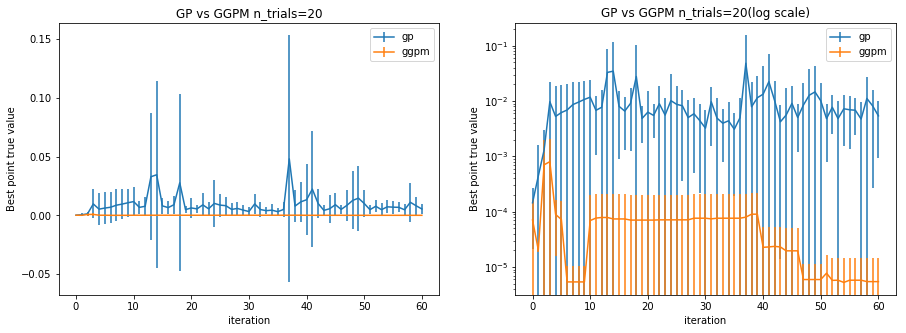

In [243]:
means, stds = return_track(agg, objective)
means_l, stds_l = return_track(agg_l, objective)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('GP vs GGPM n_trials=20')
plt.errorbar(np.arange(len(means[0])),  means[0], yerr=stds[0], label='gp')
plt.errorbar(np.arange(len(means_l[0])),  means_l[0], yerr=stds_l[0], label='ggpm')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()
plt.subplot(1,2,2)
plt.title('GP vs GGPM n_trials=20(log scale)')
plt.errorbar(np.arange(len(means[0])),  means[0], yerr=stds[0], label='gp')
plt.errorbar(np.arange(len(means_l[0])),  means_l[0], yerr=stds_l[0], label='ggpm')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()
plt.yscale('log', nonposy='clip')

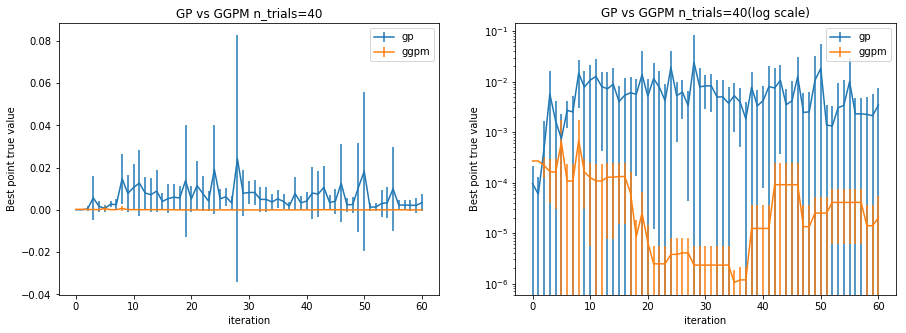

In [244]:
means, stds = return_track(agg, objective)
means_l, stds_l = return_track(agg_l, objective)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('GP vs GGPM n_trials=40')
plt.errorbar(np.arange(len(means[1])),  means[1], yerr=stds[1], label='gp')
plt.errorbar(np.arange(len(means_l[1])),  means_l[1], yerr=stds_l[1], label='ggpm')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()
plt.subplot(1,2,2)
plt.title('GP vs GGPM n_trials=40(log scale)')
plt.errorbar(np.arange(len(means[1])),  means[1], yerr=stds[1], label='gp')
plt.errorbar(np.arange(len(means_l[1])),  means_l[1], yerr=stds_l[1], label='ggpm')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()
plt.yscale('log', nonposy='clip')

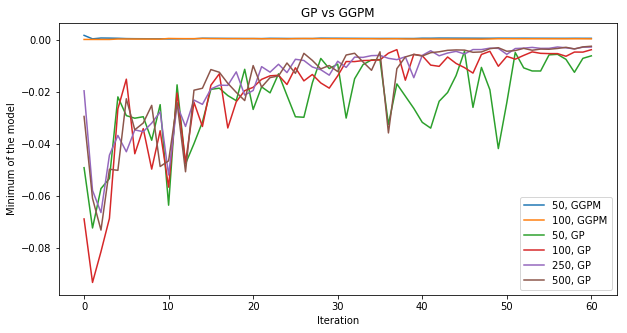

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(agg_l[0, :, 0].mean(), label='50, GGPM')
plt.plot(agg_l[1, :, 0].mean(), label='100, GGPM')

plt.plot(agg[0, :, 0].mean(), label='50, GP')
plt.plot(agg[1, :, 0].mean(), label='100, GP')
plt.plot(agg[2, :, 0].mean(), label='250, GP')
plt.plot(agg[3, :, 0].mean(), label='500, GP')
plt.title('GP vs GGPM')
plt.xlabel('Iteration')
plt.ylabel('Minimum of the model')
plt.legend()
plt.show()

In [ ]:
with open('Results/GP_vs_GGPM/GP_20_40_100_200_rosenbrock5_2d_-100_100.pickle', 'wb') as f:
    pickle.dump(agg, f)
    
with open('Results/GP_vs_GGPM/GGPM_20_40_rosenbrock5_2d_-100_100.pickle', 'wb') as f:
    pickle.dump(agg_l, f)   

# Multi fidelity vs single fidelity

2d

In [254]:
n_trials = 10
n_iteration = 80
initial_size = 15
bound = 100
dims = 2

np.random.seed(7)

objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)
init_design = GPyOpt.experiment_design.initial_design('random', feasible_region, initial_size)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

init_values = value_generator(init_design, objective, n_trials=n_trials).reshape(-1, 1)

In [255]:
ker_f = GPy.kern.RBF(dims)

In [ ]:
agg_f = []

for p in [0, 0.5, 1]:
    
    mult = []
    
    for attempt in range(10):

        X = init_design
        Y = init_values
        trials = np.ones(len(X)).reshape(-1, 1) * n_trials

        m = GPy.core.GP(X, Y, kernel=ker_f, 
                        Y_metadata={'trials': trials},
                        inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                        likelihood=GPy.likelihoods.Binomial())
        m.optimize()

        lik = GPy.likelihoods.Bernoulli()
        model_mins = []
        model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
        
        model_argmins = []
        model_argmins.append(np.argmin(m._raw_predict(X)[0]))

        for i in range(n_iteration):
            v = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X, Y, trials, m = optimization_step(X, Y, v, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials,\
                                                n_trials_low=n_trials, n_trials_high=10*n_trials,\
                                                method='laplace', kernel=ker_f, treshold_proba=p)
            model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
            model_argmins.append(np.argmin(m._raw_predict(X)[0]))
        
        mult.append(np.array([np.array(model_mins), X, Y, trials, np.array(model_argmins)]))
        
    agg_f.append(mult)
    
agg_f = np.array(agg_f)

10.0


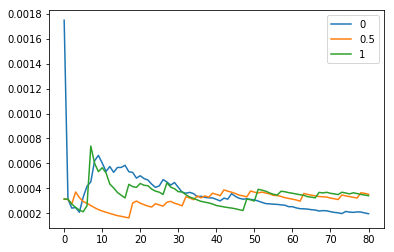

In [261]:
plt.plot(agg_f[0, :, 0].mean(), label='0')
plt.plot(agg_f[1, :, 0].mean(), label='0.5')
plt.plot(agg_f[2, :, 0].mean(), label='1')
plt.legend()

print(agg_f[2, :, 3].mean().mean())

10.0


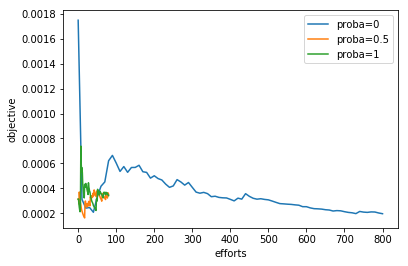

In [262]:
plt.plot(np.linspace(0, 80, 81)*10, agg_f[0, :, 0].mean(), label='proba=0')
plt.plot(np.linspace(0, 80, 81)*1, agg_f[1, :, 0].mean(), label='proba=0.5')
plt.plot(agg_f[2, :, 0].mean(), label='proba=1')
plt.legend()
plt.xlabel('efforts')
plt.ylabel('objective')

print(agg_f[1, :, 3].mean().mean())

20.0


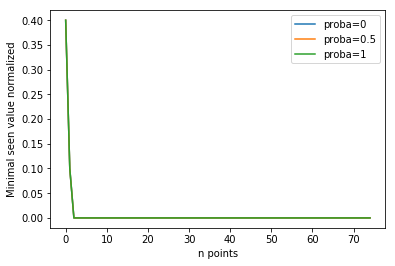

In [251]:
plt.plot(np.array([np.minimum.accumulate(agg_f[0, i, 2] / agg_f[0, i, 3]) for i in range(agg_f.shape[1])]).mean(axis=0), label='proba=0')
plt.plot(np.array([np.minimum.accumulate(agg_f[1, i, 2] / agg_f[1, i, 3]) for i in range(agg_f.shape[1])]).mean(axis=0), label='proba=0.5')
plt.plot(np.array([np.minimum.accumulate(agg_f[2, i, 2] / agg_f[2, i, 3]) for i in range(agg_f.shape[1])]).mean(axis=0), label='proba=1')
plt.legend()
plt.xlabel('n points')
plt.ylabel('Minimal seen value normalized')

print(agg_f[1, :, 3].mean().mean())

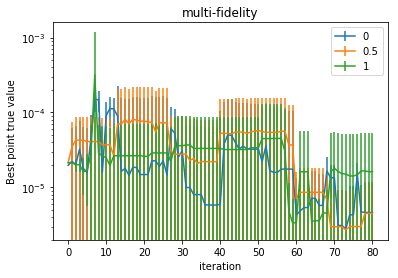

In [263]:
means, stds = return_track(agg_f, objective)

plt.title('multi-fidelity')
plt.errorbar(np.arange(len(means[1])),  means[0], yerr=stds[1], label='0')
plt.errorbar(np.arange(len(means[1])),  means[1], yerr=stds[1], label='0.5')
plt.errorbar(np.arange(len(means[2])),  means[2], yerr=stds[2], label='1')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()
plt.yscale('log', nonposy='clip')

In [40]:
with open('Results/single_vs_multi/GGPM_proba_0_0.5_1_rosenbrock5_2d_-100_100.pickle', 'wb') as f:
    pickle.dump(agg_f, f)

# Testing part

In [63]:
ker_g = GPy.kern.RBF(dims)

In [64]:
X_g = init_design
Y_g = init_values
trials_g = np.ones(len(X_g)).reshape(-1, 1) * n_trials

m_g = GPy.models.GPRegression(X_g, Y_g / trials_g, ker_g)
m_g.optimize()

model_mins_g = []
model_mins_g.append(np.min(m_g.predict(X_g)[0]))

for i in range(n_iteration):
    v_g = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
    X_g, Y_g, trials_g, m_g = optimization_step(X_g, Y_g, v_g, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials_g,\
                                                n_trials_low=n_trials, kernel=ker_g)
    model_mins_g.append(np.min(m_g.predict(X_g)[0]))

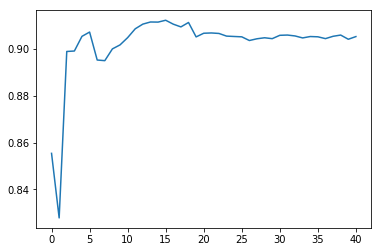

In [65]:
plt.plot(model_mins_g)

In [66]:
ker_l = GPy.kern.RBF(dims)

In [67]:
X_l_lf = init_design
Y_l_lf = init_values
trials_l_lf = np.ones(len(X_l_lf)).reshape(-1, 1) * n_trials

m_l_lf = GPy.core.GP(X_l_lf, Y_l_lf, kernel=ker_l, 
                     Y_metadata={'trials': trials_l_lf},
                     inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                     likelihood=GPy.likelihoods.Binomial())
m_l_lf.optimize()

lik = GPy.likelihoods.Bernoulli()
model_mins_l_lf = []
model_mins_l_lf.append(lik.gp_link.transf(np.min(m_l_lf._raw_predict(X_l_lf)[0])))

for i in range(n_iteration):
    v_l_lf = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
    X_l_lf, Y_l_lf, trials_l_lf, m_l_lf = optimization_step(X_l_lf, Y_l_lf, v_l_lf, lower_bounds=lower_bounds,\
                                                            upper_bounds=upper_bounds, trials=trials_l_lf,\
                                                            n_trials_low=n_trials, method='laplace',\
                                                            kernel=ker_l)
    model_mins_l_lf.append(lik.gp_link.transf(np.min(m_l_lf._raw_predict(X_l_lf)[0])))

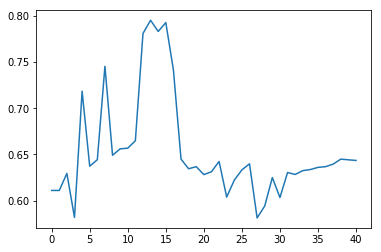

In [68]:
plt.plot(model_mins_l_lf)

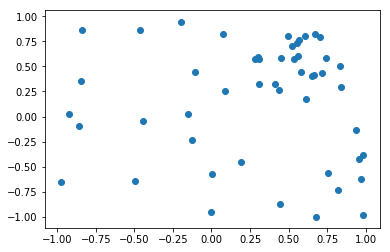

In [69]:
plt.scatter(X_l_lf[:, 0], X_l_lf[:, 1])

In [194]:
X_l_hf = init_design
Y_l_hf = init_values
trials_l_hf = np.ones(len(X_l_hf)).reshape(-1, 1) * n_trials

m_l_hf = GPy.core.GP(X_l_hf, Y_l_hf, kernel=GPy.kern.RBF(2), 
                     Y_metadata={'trials': trials_l_hf},
                     inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                     likelihood=GPy.likelihoods.Binomial())

lik = GPy.likelihoods.Bernoulli()
model_mins_l_hf = []
model_mins_l_hf.append(lik.gp_link.transf(np.min(m_l_hf._raw_predict(X_l_hf)[0])))

for i in range(n_iteration):
    v_l_hf = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
    X_l_hf, Y_l_hf, trials_l_hf, m_l_hf = optimization_step(X_l_hf, Y_l_hf, v_l_hf, lower_bounds=lower_bounds,\
                                                            upper_bounds=upper_bounds, trials=trials_l_hf,\
                                                            n_trials_low=n_trials, method='laplace',\
                                                            kernel=GPy.kern.RBF(2))
    model_mins_l_hf.append(lik.gp_link.transf(np.min(m_l_hf._raw_predict(X_l_hf)[0])))

bad point


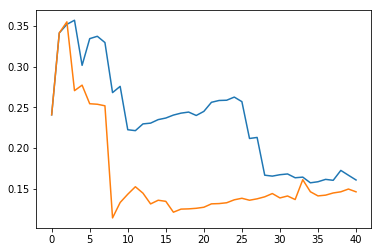

In [195]:
plt.plot(model_mins_l_lf)
plt.plot(model_mins_l_hf)

In [16]:
xs = np.linspace(-2, 2, 100)
ys = np.linspace(-2, 2, 100)
xs, ys = np.meshgrid(xs, ys)

In [199]:
values = lik.gp_link.transf(m_l_hf._raw_predict(np.dstack([xs, ys]).reshape(10000, 2))[0].reshape(100, 100))

In [131]:
values = m_g_lf.predict(np.dstack([xs, ys]).reshape(10000, 2))[0].reshape(100, 100)

In [24]:
values = objective(np.dstack([xs, ys]).reshape(10000, 2)).reshape(100, 100)

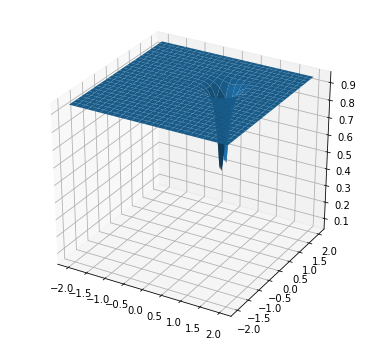

In [25]:
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(1, 2, 1, projection='3d')

p = ax.plot_surface(xs, ys, values, rstride=4, cstride=4, linewidth=0)